In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
import utils.data
from utils.layers import Encoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
data = utils.data.get_dataset(mode='mel')

In [3]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [4]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [5]:
X_train.shape

(6989, 130, 128)

In [6]:
X_train = tf.expand_dims(X_train, axis=-1)
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

In [7]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [8]:
# Using the functional API to build a model
input = Input(shape=(X_train.shape[1:]))
conv1 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(input)
conv2 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(conv1)
# Pooling layer to reduce the dimensionality of the output (downsampling)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv2)
# Batch normalization to normalize the activations of the previous layer at each batch
ap = BatchNormalization()(ap)
conv3 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv3)
ap = BatchNormalization()(ap)
conv4 = Conv2D(filters=512, kernel_size=4, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
# Global average pooling to reduce the dimensionality of the output (no parameters to learn)
ap = GlobalAveragePooling2D()(conv4)
dense1 = Dense(256, activation='relu')(ap)
dense1 = Dropout(0.1)(dense1)
dense2 = Dense(128, activation='relu')(dense1)
# Output layer with softmax activation
output = Dense(len(data["mapping"]), activation='softmax')(dense2)
conv_model = tf.keras.Model(inputs=input, outputs=output)


In [9]:
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 130, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 126, 256)     2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 124, 256)     590080    
                                                                 
 average_pooling2d (AverageP  (None, 63, 62, 256)      0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 63, 62, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 60, 256)       590080

In [10]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [11]:
conv_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [12]:
conv_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_valid, Y_valid), verbose=1, callbacks=es)

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model/average_pooling2d/AvgPoolGrad' defined at (most recent call last):
    File "d:\programs\anaconda3\envs\ait\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\programs\anaconda3\envs\ait\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "d:\programs\anaconda3\envs\ait\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "d:\programs\anaconda3\envs\ait\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "d:\programs\anaconda3\envs\ait\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\pczum\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\pczum\AppData\Local\Temp\ipykernel_15428\2733659101.py", line 1, in <module>
      conv_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_valid, Y_valid), verbose=1, callbacks=es)
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "d:\programs\anaconda3\envs\ait\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/average_pooling2d/AvgPoolGrad'
OOM when allocating tensor with shape[64,126,124,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/average_pooling2d/AvgPoolGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1476]

94/94 [==============================] - 3s 20ms/step
              precision    recall  f1-score   support

           0       0.29      0.21      0.24       300
           1       0.69      0.99      0.81       299
           2       0.49      0.60      0.54       299
           3       0.90      0.74      0.81       299
           4       0.76      0.87      0.81       299
           5       0.73      0.71      0.72       297
           6       0.70      0.64      0.67       300
           7       0.94      0.79      0.86       300
           8       0.56      0.51      0.53       300
           9       0.43      0.44      0.43       299

    accuracy                           0.65      2992
   macro avg       0.65      0.65      0.64      2992
weighted avg       0.65      0.65      0.64      2992



<Axes: >

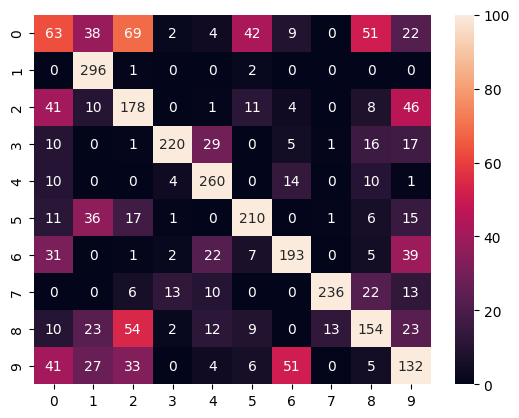

In [ ]:
preds = conv_model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [ ]:
conv_model.save('./models/conv.h5')

In [ ]:
import librosa
from utils.data import *

In [ ]:
def predict_genre(signal, sr=22050):
    segments = []
    for i in range(number_of_segments):
        # calculating start and finish index of the segment
        start = samples_per_segment * i
        end = start + samples_per_segment
        # Calculating the mfcc of the segment
        feature = librosa.feature.melspectrogram(y=signal[start:end], sr=sr, n_mels=n_mfcc_mel, n_fft=n_fft, hop_length=hop_length)
        feature = (librosa.power_to_db(feature, ref=np.max) + 40) / 40
        feature = feature.T.tolist()
        if len(feature) == num_mfcc_vectors_per_segment:
            # Adding the mfcc and label to our data
            segments.append(feature)
        
    segments = np.array(segments)
    aggr = np.zeros(10)
    for segment in segments:
        segment = tf.expand_dims(segment, axis=-1)
        segment = tf.expand_dims(segment, axis=0)
        aggr[np.argmax(conv_model.predict(segment, verbose=0))] += 1
    pred = np.argmax(aggr)
    return data["mapping"][pred]

In [ ]:
for i in range(90, 100):
    signal, sr = librosa.load('./Data/genres_original/classical/classical.000'+str(i)+'.wav', sr=22050)
    print(predict_genre(signal, sr))

classical
classical
classical
classical
classical
classical
classical
classical
classical
classical


In [ ]:
signal, sr = librosa.load('./demo/Symphony-no.-40-in-G-minor-K.-550-I.-Molto-Allegro.mp3')
print(predict_genre(signal, sr))

classical


In [ ]:
signal, sr = librosa.load('./demo/take-five.mp3')
print(predict_genre(signal, sr))

jazz


In [ ]:
signal, sr = librosa.load('./demo/The Offspring - You\'re Gonna Go Far, Kid (128 kbps).mp3')
print(predict_genre(signal, sr))

classical
